In [1]:
!pip install optuna
!pip install pytorch-ignite

import os

from google.colab import drive
drive.mount('/content/drive')

dataset_path = '/content/drive/My Drive/Recyclables Classification Dataset/images/images'

save_dir = '/content/drive/My Drive/Recyclables Classification Dataset/optuna_studies'

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 3.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x

**important code snippets

In [2]:
"""Dataset: Recyclable and Household Waste Classification
Version: 1.0
Date: 5/18/2024

This dataset contains images of various recyclable materials, general waste, and household items for the purpose of waste classification and recycling research.

Dataset Structure:
The dataset is organized into a hierarchical folder structure as follows:

- images/
  - Plastic water bottles/
    - default/
      - image1.png
      - image2.png
      - ...
    - real_world/
      - image1.png
      - image2.png
      - ...
  - Plastic soda bottles/
    - default/
      - image1.png
      - image2.png
      - ...
    - real_world/
      - image1.png
      - image2.png
      - ...
  - Plastic detergent bottles/
    - default/
      - image1.png
      - image2.png
      - ...
    - real_world/
      - image1.png
      - image2.png
      - ...
  - ...

The "images" folder contains subfolders, each representing a specific waste category or item. The subfolder names serve as the labels for the respective categories.

Within each category subfolder, there are two folders:
1. "default": Contains standard or studio-like images of the waste item.
2. "real_world": Contains images of the waste item in real-world scenarios or environments.

All images in the dataset are in the PNG format.

Waste Categories:
The dataset covers the following waste categories and items:
- Plastic: water bottles, soda bottles, detergent bottles, shopping bags, trash bags, food containers, disposable cutlery, straws, cup lids
- Paper and Cardboard: newspaper, office paper, magazines, cardboard boxes, cardboard packaging
- Glass: beverage bottles, food jars, cosmetic containers
- Metal: aluminum soda cans, aluminum food cans, steel food cans, aerosol cans
- Organic Waste: food waste (fruit peels, vegetable scraps), eggshells, coffee grounds, tea bags
- Textiles: clothing, shoes
"""

import os, re, random, time
import optuna.visualization as vis
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import RandomErasing
from sklearn.metrics import accuracy_score, f1_score


# Define the path to the dataset
# dataset_path = r'C:\Users\Vaquita\Downloads\Recyclables Classification Dataset\images\images'

# Define transformations for training, validation, and test sets
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly crop and resize to 224x224
    transforms.RandomHorizontalFlip(p=0.4),  # Flip horizontally with 50% probability
    transforms.RandomRotation(degrees=15),  # Rotate by up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, saturation, and hue
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet mean and std
    RandomErasing(p=0.3, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random')  # Randomly erase a rectangle region with 50% probability
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=train_transforms)

# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply validation/test transformations to the validation and test sets
val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

1. Problem Definition

---

1. Data Exploration and Visualization

1.1 Load dataset and visualize the images

In [ ]:
import os, re, random
from PIL import Image
import matplotlib.pyplot as plt

# Define the path to the dataset
# dataset_path = r'C:\Users\Vaquita\Downloads\Recyclables Classification Dataset\images\images'

# Function to load and visualize a random patch of images from a given folder
def visualize_random_images(folder_path, title, num_images=5):
    images = []
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    random_files = random.sample(file_names, min(num_images, len(file_names)))

    for file_name in random_files:
        img_path = os.path.join(folder_path, file_name)
        img = Image.open(img_path)
        images.append(img)

    # Plot the images
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    fig.suptitle(title)
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.axis('off')
    plt.show()

# Function to traverse the dataset and visualize random images
def visualize_dataset(dataset_path, num_images=5):
    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)
        if os.path.isdir(category_path):
            for subfolder in ['default', 'real_world']:
                subfolder_path = os.path.join(category_path, subfolder)
                if os.path.isdir(subfolder_path):
                    title = f"{category} - {subfolder}"
                    visualize_random_images(subfolder_path, title, num_images)

# Visualize the dataset
visualize_dataset(dataset_path)

1.2. Class Dist.

{'aerosol_cans': {'default': 250, 'real_world': 250}, 'aluminum_food_cans': {'default': 250, 'real_world': 250}, 'aluminum_soda_cans': {'default': 250, 'real_world': 250}, 'cardboard_boxes': {'default': 250, 'real_world': 250}, 'cardboard_packaging': {'default': 250, 'real_world': 250}, 'clothing': {'default': 250, 'real_world': 250}, 'coffee_grounds': {'default': 250, 'real_world': 250}, 'disposable_plastic_cutlery': {'default': 250, 'real_world': 250}, 'food_waste': {'default': 250, 'real_world': 250}, 'glass_cosmetic_containers': {'default': 250, 'real_world': 250}, 'glass_food_jars': {'default': 250, 'real_world': 249}, 'magazines': {'default': 250, 'real_world': 250}, 'newspaper': {'default': 250, 'real_world': 250}, 'office_paper': {'default': 250, 'real_world': 250}, 'paper_cups': {'default': 250, 'real_world': 250}, 'plastic_cup_lids': {'default': 250, 'real_world': 250}, 'plastic_detergent_bottles': {'default': 250, 'real_world': 250}, 'plastic_food_containers': {'default': 25

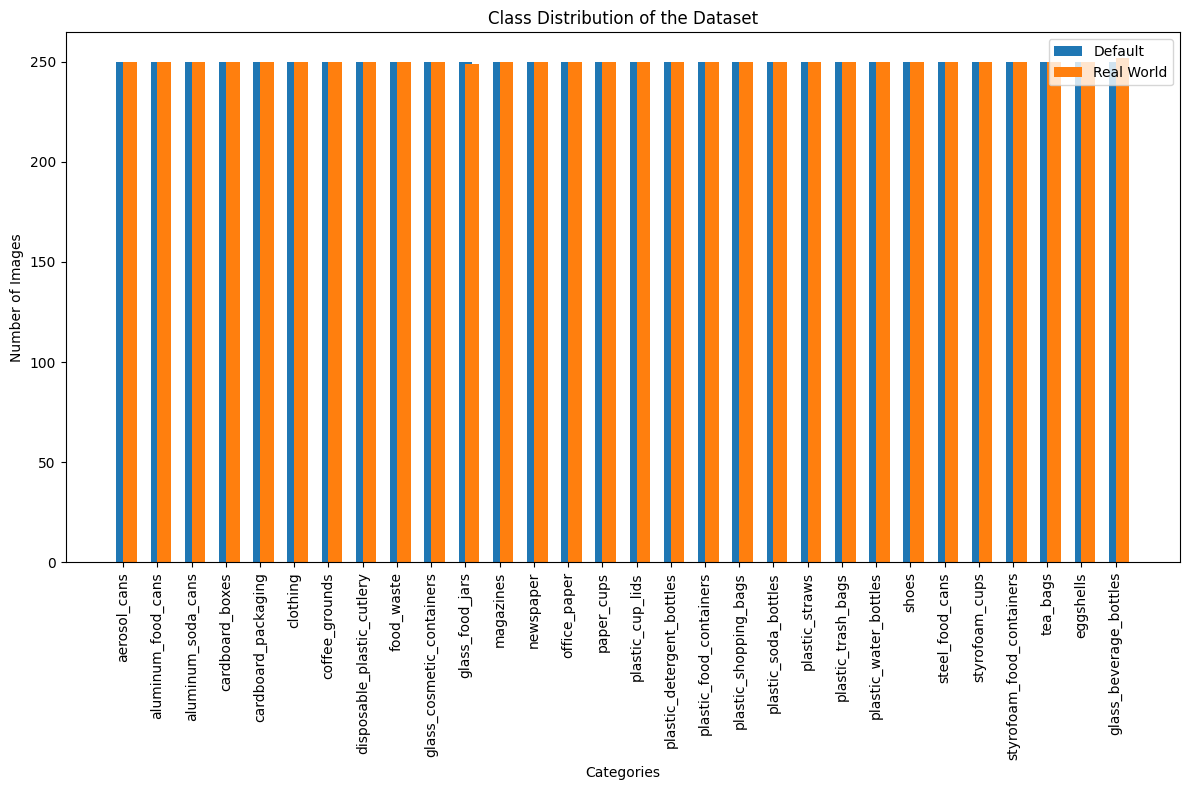

In [ ]:

# Function to count images in each category and subfolder
def count_images(dataset_path):
    class_counts = {}
    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)
        if os.path.isdir(category_path):
            class_counts[category] = {'default': 0, 'real_world': 0}
            for subfolder in ['default', 'real_world']:
                subfolder_path = os.path.join(category_path, subfolder)
                if os.path.isdir(subfolder_path):
                    num_images = len([f for f in os.listdir(subfolder_path) if f.endswith('.png')])
                    class_counts[category][subfolder] = num_images
    return class_counts

# Function to visualize the class distribution
def visualize_class_distribution(class_counts):
    categories = list(class_counts.keys())
    default_counts = [class_counts[category]['default'] for category in categories]
    real_world_counts = [class_counts[category]['real_world'] for category in categories]

    x = range(len(categories))

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.bar(x, default_counts, width=0.4, label='Default', align='center')
    ax.bar(x, real_world_counts, width=0.4, label='Real World', align='edge')

    ax.set_xlabel('Categories')
    ax.set_ylabel('Number of Images')
    ax.set_title('Class Distribution of the Dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=90)
    ax.legend()

    plt.tight_layout()
    plt.show()

# Count the images in the dataset
class_counts = count_images(dataset_path)
print(class_counts)
# Visualize the class distribution
visualize_class_distribution(class_counts)

2. Aug + Data loaders

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import RandomErasing

# Define transformations for training, validation, and test sets
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly crop and resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),  # Flip horizontally with 50% probability
    transforms.RandomRotation(degrees=15),  # Rotate by up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, saturation, and hue
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet mean and std
    RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random')  # Randomly erase a rectangle region with 50% probability
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=train_transforms)

# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply validation/test transformations to the validation and test sets
val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

Attempt 3 with training time + paramters

In [3]:
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    accuracies = []
    f1_scores = []

    for epoch in range(num_epochs):
        # Training loop
        model.train()
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train

        # Evaluation on the validation set
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        val_loss /= len(val_loader)
        val_accuracy = correct_val / total_val
        val_f1 = f1_score(all_labels, all_preds, average='weighted')

        accuracies.append(val_accuracy)
        f1_scores.append(val_f1)

        print(f'Epoch [{epoch+1}/{num_epochs}] - Training Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}')

    return accuracies, f1_scores

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the number of classes
num_classes = len(dataset.classes)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of models to train
model_configs = [
    ("ResNet34", models.resnet34, "fc"),
    ("ResNeXt50", models.resnext50_32x4d, "fc"),
    ("EfficientNetV2_s", models.efficientnet_v2_s, "classifier[1]"),
    ("ConvNeXt_tiny", models.convnext_tiny, "classifier[2]"),
    ("EfficientNetV2_m", models.efficientnet_v2_m, "classifier[1]"),
    ("EfficientNet_b3", models.efficientnet_b3, "classifier[1]"),
    ("EfficientNet_b5", models.efficientnet_b5, "classifier[1]")
]

# Dictionary to store results
results = {}

# Train and evaluate each model
for model_name, model_func, classifier_attr in model_configs:
    model = model_func(pretrained=True)
    classifier_layer = eval(f"model.{classifier_attr}")
    classifier_layer = nn.Linear(classifier_layer.in_features, num_classes)
    exec(f"model.{classifier_attr} = classifier_layer")
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Calculate the number of parameters
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Training and evaluating {model_name}")
    start_time = time.time()
    accuracies, f1_scores = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)
    end_time = time.time()
    training_time = end_time - start_time

    results[model_name] = {
        "accuracies": accuracies,
        "f1_scores": f1_scores,
        "training_time": training_time,
        "num_params": num_params
    }

    print(f"{model_name} - Training Time: {training_time:.2f} seconds, Number of Parameters: {num_params}")

# Plotting the results
epochs = range(1, 11)

plt.figure(figsize=(12, 6))

for model_name, metrics in results.items():
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy', color='tab:blue')
    ax1.plot(epochs, metrics["accuracies"], label=f'{model_name} Accuracy', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('F1 Score', color='tab:red')
    ax2.plot(epochs, metrics["f1_scores"], label=f'{model_name} F1 Score', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    fig.tight_layout()
    plt.title(f'{model_name} - Validation Accuracy and F1 Score')
    fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
    plt.show()

# Display training time and number of parameters
for model_name, metrics in results.items():
    print(f"{model_name} - Training Time: {metrics['training_time']:.2f} seconds, Number of Parameters: {metrics['num_params']}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 74.3MB/s]


Training and evaluating ResNet34


KeyboardInterrupt: 

In [ ]:
print(results)

{'ResNet34': {'accuracies': [0.5213333333333333, 0.642, 0.6706666666666666, 0.7353333333333333, 0.7426666666666667, 0.7486666666666667, 0.7483333333333333, 0.7693333333333333, 0.755, 0.763], 'f1_scores': [0.5081295033529909, 0.631034418209872, 0.675525849660733, 0.7294248834904548, 0.7461875395986077, 0.742482268501885, 0.7468793306416618, 0.7689829459947185, 0.751870157636376, 0.763699358130046], 'training_time': 2810.7038106918335, 'num_params': 21300062}, 'ResNeXt50': {'accuracies': [0.5723333333333334, 0.6693333333333333, 0.7226666666666667, 0.7616666666666667, 0.7223333333333334, 0.7153333333333334, 0.7683333333333333, 0.7613333333333333, 0.748, 0.7673333333333333], 'f1_scores': [0.5629588813266339, 0.6580377909059748, 0.7122910453352991, 0.763345304486588, 0.7093089421662162, 0.719731684315688, 0.7684183675718466, 0.7582708254245388, 0.7499190438486797, 0.7656365780858606], 'training_time': 1620.0616106987, 'num_params': 23041374}, 'EfficientNetV2_s': {'accuracies': [0.753, 0.774

In [ ]:
import altair as alt
import pandas as pd
alt.renderers.enable('colab')


results = {
    'ResNet34': {'accuracies': [0.5213333333333333, 0.642, 0.6706666666666666, 0.7353333333333333, 0.7426666666666667, 0.7486666666666667, 0.7483333333333333, 0.7693333333333333, 0.755, 0.763], 'f1_scores': [0.5081295033529909, 0.631034418209872, 0.675525849660733, 0.7294248834904548, 0.7461875395986077, 0.742482268501885, 0.7468793306416618, 0.7689829459947185, 0.751870157636376, 0.763699358130046], 'training_time': 2810.7038106918335, 'num_params': 21300062},
    'ResNeXt50': {'accuracies': [0.5723333333333334, 0.6693333333333333, 0.7226666666666667, 0.7616666666666667, 0.7223333333333334, 0.7153333333333334, 0.7683333333333333, 0.7613333333333333, 0.748, 0.7673333333333333], 'f1_scores': [0.5629588813266339, 0.6580377909059748, 0.7122910453352991, 0.763345304486588, 0.7093089421662162, 0.719731684315688, 0.7684183675718466, 0.7582708254245388, 0.7499190438486797, 0.7656365780858606], 'training_time': 1620.0616106987, 'num_params': 23041374},
    'EfficientNetV2_s': {'accuracies': [0.753, 0.7746666666666666, 0.8036666666666666, 0.7786666666666666, 0.8203333333333334, 0.825, 0.8083333333333333, 0.838, 0.8233333333333334, 0.8183333333333334], 'f1_scores': [0.7506080839230885, 0.7766669739899547, 0.8022736579305763, 0.7752619196722441, 0.819052489478621, 0.8257148511217407, 0.8033361043247143, 0.8372094019496465, 0.8231842443006527, 0.8171476424007671], 'training_time': 1392.4612758159637, 'num_params': 20215918},
    'ConvNeXt_tiny': {'accuracies': [0.7553333333333333, 0.7543333333333333, 0.78, 0.7636666666666667, 0.7896666666666666, 0.802, 0.8056666666666666, 0.8166666666666667, 0.7763333333333333, 0.8043333333333333], 'f1_scores': [0.7483682606547979, 0.7410241796239666, 0.7733772371961729, 0.756018024119291, 0.7879340362242587, 0.7970192969009205, 0.8023133843587184, 0.8193266015160069, 0.7835362877257446, 0.8067698673197111], 'training_time': 2863.425936937332, 'num_params': 27843198},
    'EfficientNetV2_m': {'accuracies': [0.683, 0.759, 0.6263333333333333, 0.7753333333333333, 0.7826666666666666, 0.8046666666666666, 0.8183333333333334, 0.7963333333333333, 0.8033333333333333, 0.808], 'f1_scores': [0.670277520946631, 0.7572790837692275, 0.6413093514798639, 0.7689944440135893, 0.7795427358232019, 0.803577344399984, 0.8144420735087179, 0.7950387940895071, 0.8038970880079731, 0.8075271151286207], 'training_time': 2304.7926330566406, 'num_params': 52896786},
    'EfficientNet_b3': {'accuracies': [0.8243333333333334, 0.8326666666666667, 0.8226666666666667, 0.8323333333333334, 0.84, 0.8536666666666667, 0.8426666666666667, 0.859, 0.8506666666666667, 0.848], 'f1_scores': [0.8183829616918221, 0.8303248456348703, 0.8131747612176526, 0.8269887697061891, 0.8368019992733163, 0.8520778277018118, 0.8399803435908745, 0.8571353650825546, 0.8497957927398513, 0.8472812052152597], 'training_time': 1274.0337572097778, 'num_params': 10742342},
    'EfficientNet_b5': {'accuracies': [0.711, 0.757, 0.7863333333333333, 0.8103333333333333, 0.8103333333333333, 0.8076666666666666, 0.8056666666666666, 0.8096666666666666, 0.8266666666666667, 0.8236666666666667], 'f1_scores': [0.7057630213068112, 0.7624198603488529, 0.7842713314987089, 0.8077602841104768, 0.809159649294959, 0.8063334891852098, 0.798851832525373, 0.8100004334255643, 0.8270489294513554, 0.82185869892906], 'training_time': 2203.1013729572296, 'num_params': 28402254}
}

# Convert training time from seconds to minutes for plotting
for model_name, metrics in results.items():
    metrics['training_time'] /= 60

# Prepare the data for Altair
data = []
for model_name, metrics in results.items():
    data.append({
        'Model': model_name,
        'Training Time (minutes)': metrics['training_time'],
        'F1 Score': metrics['f1_scores'][-1],
        'Accuracy': metrics['accuracies'][-1],  # Assuming you have accuracy data
        'Number of Parameters': metrics['num_params']
    })

df = pd.DataFrame(data)

# Ensure the training time is correctly interpreted as a numeric type
df['Training Time (minutes)'] = pd.to_numeric(df['Training Time (minutes)'])

# Create the scatter plot using Altair
scatter_plot = alt.Chart(df).mark_circle().encode(
    x=alt.X('Training Time (minutes):Q', title='Training Time (minutes)', scale=alt.Scale(domain=[10, df['Training Time (minutes)'].max()])),
    y=alt.Y('F1 Score:Q', title='F1 Score', scale=alt.Scale(domain=[0.7, 1.0])),
    size=alt.Size('Number of Parameters:Q', title='Number of Parameters', scale=alt.Scale(type='log', range=[1000, 10000])),  # Increase the range for bigger dots
    color=alt.Color('Model:N', legend=alt.Legend(title='Model Name')),
    tooltip=[
        alt.Tooltip('Model:N', title='Model'),
        alt.Tooltip('Training Time (minutes):Q', title='Training Time (minutes)', format='.2f'),
        alt.Tooltip('F1 Score:Q', title='F1 Score', format='.2f'),
        alt.Tooltip('Accuracy:Q', title='Accuracy', format='.2f'),
        alt.Tooltip('Number of Parameters:Q', title='Number of Parameters', format=',')
    ]
).properties(
    title='Model Performance: F1 Score vs Training Time',
    width=800,
    height=600
)

# Display the plot
scatter_plot

alt.Chart(...)

![Models Performance](https://i.imgur.com/ZpHKEqM.png)


4. Hypp Tuning

4. Trying Optuna Hypp opt.

Attempt 4 GIMME SOME OF DEM GOOD PARAMTERS GODDAMIT

In [4]:
import optuna
from optuna.trial import TrialState
import torch.optim as optim
from torch.utils.data import DataLoader
import time
import torch.nn as nn
import torchvision.models as models
import pickle

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_float('lr', 1e-6, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 24, 32])
    optimizer_name = trial.suggest_categorical('optimizer', ['SGD', 'Adam', 'AdamW'])
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)

    # Update data loaders with the new batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Initialize the model
    model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    model = model.to(device)

    # Get the optimizer
    optimizer = get_optimizer(optimizer_name, model.parameters(), lr, weight_decay)

    # Train and evaluate the model
    print(f"Training EfficientNet_b3 with lr={lr}, batch_size={batch_size}, optimizer={optimizer_name}, weight_decay={weight_decay}")
    start_time = time.time()
    accuracies, f1_scores = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=9)
    end_time = time.time()
    training_time = end_time - start_time

    # Return the best validation accuracy
    return max(accuracies)

# Function to get the optimizer
def get_optimizer(optimizer_name, model_params, lr, weight_decay):
    if optimizer_name == 'Adam':
        return optim.Adam(model_params, lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        return optim.SGD(model_params, lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'RMSprop':
        return optim.RMSprop(model_params, lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'AdamW':
        return optim.AdamW(model_params, lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', storage=f'sqlite:///{save_dir}/example_study.db', study_name='example_study', load_if_exists=True)
study.optimize(objective, n_trials=100)

# Save the study results to a file (optional)
with open(os.path.join(save_dir, "study.pkl"), "wb") as f:
    pickle.dump(study, f)

# Load the study results from a file (optional)
with open(os.path.join(save_dir, "study.pkl"), "rb") as f:
    study = pickle.load(f)

# Display the best trial
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Function to resume the study
def resume_study(study_name, storage):
    study = optuna.load_study(study_name=study_name, storage=storage)
    study.optimize(objective, n_trials=100)
    return study

# Example usage to resume the study
study = resume_study("example_study", f'sqlite:///{save_dir}/example_study.db')

[I 2024-07-23 21:22:28,973] Using an existing study with name 'example_study' instead of creating a new one.
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 58.0MB/s]


Training EfficientNet_b3 with lr=4.7048315018006954e-05, batch_size=32, optimizer=Adam, weight_decay=3.085559471886346e-05


[W 2024-07-23 21:22:32,583] Trial 15 failed with parameters: {'lr': 4.7048315018006954e-05, 'batch_size': 32, 'optimizer': 'Adam', 'weight_decay': 3.085559471886346e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-4-2251bbd7c0d4>", line 34, in objective
    accuracies, f1_scores = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=9)
  File "<ipython-input-3-3821a1cd28dd>", line 10, in train_and_evaluate
    for images, labels in train_loader:
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 631, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1329, in _next_data
    idx, data = self._get_data()
  File "/usr/local/lib/python3.10/dist

KeyboardInterrupt: 

Optuna viz

In [ ]:
import optuna.visualization as vis
import optuna
from optuna.trial import TrialState
import torch.optim as optim
from torch.utils.data import DataLoader
import time
import torch.nn as nn
import torchvision.models as models
import pickle
# Load the study
study = optuna.load_study(
    study_name='example_study',
    storage=f'sqlite:///{save_dir}/example_study.db'
)

# Plot the optimization history
vis.plot_optimization_history(study).show()

# Plot the hyperparameter importance
vis.plot_param_importances(study).show()

best pars

In [ ]:
# Get all trials
all_trials = study.trials

# Filter out incomplete trials
completed_trials = [t for t in all_trials if t.state == TrialState.COMPLETE]

# Sort trials by their objective value in descending order
sorted_trials = sorted(completed_trials, key=lambda t: t.value, reverse=True)

# Extract the top 5 trials
top_n = 5
best_trials = sorted_trials[:top_n]

# Display the best trials
print(f"Top {top_n} trials:")
for i, trial in enumerate(best_trials):
    print(f"Trial {i+1}:")
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

Top 5 trials:
Trial 1:
  Value: 0.883
  Params: 
    lr: 6.881098092316187e-05
    batch_size: 32
    optimizer: Adam
    weight_decay: 4.6048934792804534e-05
Trial 2:
  Value: 0.8813333333333333
  Params: 
    lr: 6.346231440966479e-05
    batch_size: 32
    optimizer: Adam
    weight_decay: 3.097591182840527e-05
Trial 3:
  Value: 0.868
  Params: 
    lr: 0.00041747132203531507
    batch_size: 32
    optimizer: Adam
    weight_decay: 3.459011662471061e-05
Trial 4:
  Value: 0.8506666666666667
  Params: 
    lr: 0.0006605652101928982
    batch_size: 16
    optimizer: AdamW
    weight_decay: 4.439059381412331e-05
Trial 5:
  Value: 0.79
  Params: 
    lr: 6.953823418991795e-06
    batch_size: 16
    optimizer: Adam
    weight_decay: 8.058453940133268e-06


Train Final model

In [12]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import EarlyStopping, ModelCheckpoint
from ignite.metrics import Accuracy, Loss
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import os
import json

# Define the number of classes
num_classes = len(dataset.classes)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# EfficientNetB3 model with dropout and regularization
model = models.efficientnet_b3(pretrained=True)
model.classifier[1] = nn.Sequential(
    nn.Dropout(0.5),  # Add dropout
    nn.Linear(model.classifier[1].in_features, num_classes)
)
model = model.to(device)

# Best trial parameters
best_params = {
    "lr": 6.881098092316187e-05,
    "batch_size": 32,
    "optimizer": "Adam",
    "weight_decay": 4.6048934792804534e-05
}

# Define the optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=best_params["lr"], weight_decay=best_params["weight_decay"])

# Define the loss function
criterion = nn.CrossEntropyLoss()

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model, metrics={'accuracy': Accuracy(), 'loss': Loss(criterion)}, device=device)

# Early stopping handler
early_stopping_handler = EarlyStopping(patience=5, score_function=lambda engine: -engine.state.metrics['loss'], trainer=trainer)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)

# Attach handlers to the evaluator
evaluator.add_event_handler(Events.COMPLETED, early_stopping_handler)

# Store the validation loss after each epoch
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(val_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics['loss']
    scheduler.step(val_loss)  # Use the validation loss for the scheduler

trainer.add_event_handler(Events.EPOCH_COMPLETED, lambda engine: evaluator.run(val_loader))

# Model checkpoint handler
checkpointer = ModelCheckpoint(dirname=save_dir, filename_prefix="best_model", save_interval=1, n_saved=5, create_dir=True, require_empty=False)

# Attach the checkpointer to the trainer
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'model': model})

# Lists to store metrics
training_losses = []
validation_losses = []
validation_accuracies = []
training_accuracies = []

# Function to log training loss
@trainer.on(Events.ITERATION_COMPLETED(every=100))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}] Iteration[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

# Function to log metrics at the end of each epoch
@trainer.on(Events.EPOCH_COMPLETED)
def log_epoch_results(engine):
    # Evaluate on training data
    evaluator.run(train_loader)
    train_metrics = evaluator.state.metrics
    train_accuracy = train_metrics['accuracy']
    train_loss = train_metrics['loss']
    training_losses.append(train_loss)
    training_accuracies.append(train_accuracy)

    # Evaluate on validation data
    evaluator.run(val_loader)
    val_metrics = evaluator.state.metrics
    val_accuracy = val_metrics['accuracy']
    val_loss = val_metrics['loss']
    validation_losses.append(val_loss)
    validation_accuracies.append(val_accuracy)

    print(f"Epoch[{engine.state.epoch}] Training - Avg accuracy: {train_accuracy:.2f} Avg loss: {train_loss:.2f}")
    print(f"Epoch[{engine.state.epoch}] Validation - Avg accuracy: {val_accuracy:.2f} Avg loss: {val_loss:.2f}")

# Run the training loop
trainer.run(train_loader, max_epochs=50)

# Define the path for the JSON file
metrics_path = os.path.join(save_dir, 'metrics.json')

# Save the metrics to a file
metrics = {
    "training_losses": training_losses,
    "validation_losses": validation_losses,
    "training_accuracies": training_accuracies,
    "validation_accuracies": validation_accuracies
}
with open(metrics_path, 'w') as f:
    json.dump(metrics, f)

Epoch[1] Iteration[100] Loss: 2.96
Epoch[1] Iteration[200] Loss: 2.29
Epoch[1] Iteration[300] Loss: 1.58


ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: save() got an unexpected keyword argument 'save_interval'


TypeError: save() got an unexpected keyword argument 'save_interval'

New attempt new code

earlz stopping

In [14]:
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define the model with dropout and regularization
model = models.efficientnet_b3(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(
    nn.Dropout(0.5),  # Add dropout with 50% probability
    nn.Linear(num_ftrs, num_classes)
)
model = model.to(device)

# Define the optimizer with the best trial parameters
optimizer = optim.Adam(model.parameters(), lr=6.881098092316187e-05, weight_decay=4.6048934792804534e-05)

# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Early stopping parameters
early_stopping_patience = 5
best_val_loss = float('inf')
early_stopping_counter = 0

# Modified train_and_evaluate function with early stopping and learning rate reduction
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10, save_dir=save_dir):
    accuracies = []
    f1_scores = []

    # Early stopping parameters
    early_stopping_patience = 5
    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        # Training loop
        model.train()
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train

        # Evaluation on the validation set
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        val_loss /= len(val_loader)
        val_accuracy = correct_val / total_val
        val_f1 = f1_score(all_labels, all_preds, average='weighted')

        accuracies.append(val_accuracy)
        f1_scores.append(val_f1)

        print(f'Epoch [{epoch+1}/{num_epochs}] - Training Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}')

        # Save the model after each epoch
        torch.save(model.state_dict(), os.path.join(save_dir, f'efficientnet_b3_epoch_{epoch+1}.pth'))

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping triggered")
                break

        # Step the scheduler
        scheduler.step(val_loss)

    return accuracies, f1_scores

# Train and evaluate the model
accuracies, f1_scores = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=50, save_dir=save_dir)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/50] - Training Accuracy: 0.3974, Validation Loss: 1.2495, Validation Accuracy: 0.7293, Validation F1 Score: 0.7190
Epoch [2/50] - Training Accuracy: 0.7281, Validation Loss: 0.6304, Validation Accuracy: 0.8223, Validation F1 Score: 0.8180
Epoch [3/50] - Training Accuracy: 0.8200, Validation Loss: 0.4789, Validation Accuracy: 0.8497, Validation F1 Score: 0.8474
Epoch [4/50] - Training Accuracy: 0.8700, Validation Loss: 0.4163, Validation Accuracy: 0.8650, Validation F1 Score: 0.8617
Epoch [5/50] - Training Accuracy: 0.8975, Validation Loss: 0.3794, Validation Accuracy: 0.8747, Validation F1 Score: 0.8735
Epoch [6/50] - Training Accuracy: 0.9169, Validation Loss: 0.3668, Validation Accuracy: 0.8813, Validation F1 Score: 0.8806
Epoch [7/50] - Training Accuracy: 0.9361, Validation Loss: 0.3803, Validation Accuracy: 0.8760, Validation F1 Score: 0.8740
Epoch [8/50] - Training Accuracy: 0.9419, Validation Loss: 0.3895, Validation Accuracy: 0.8740, Validation F1 Score: 0.8718
Epoch [9

unfreeze some layers

In [15]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import f1_score
import os

# Load the pretrained model
model = models.efficientnet_b3(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(
    nn.Dropout(0.5),  # Add dropout with 50% probability
    nn.Linear(num_ftrs, num_classes)
)
model = model.to(device)

# Number of blocks to unfreeze
num_unfrozen_blocks = 1

# Unfreeze the last few layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last `num_unfrozen_blocks` blocks and classifier
for param in model.features[-num_unfrozen_blocks:].parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True

# Define the optimizer with the best trial parameters
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=6.881098092316187e-05, weight_decay=4.6048934792804534e-05)

# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Early stopping parameters
early_stopping_patience = 5
best_val_loss = float('inf')
early_stopping_counter = 0

# Modified train_and_evaluate function with early stopping and learning rate reduction
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10, save_dir=save_dir, num_unfrozen_blocks=1):
    accuracies = []
    f1_scores = []

    # Early stopping parameters
    early_stopping_patience = 5
    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        # Training loop
        model.train()
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train

        # Evaluation on the validation set
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        val_loss /= len(val_loader)
        val_accuracy = correct_val / total_val
        val_f1 = f1_score(all_labels, all_preds, average='weighted')

        accuracies.append(val_accuracy)
        f1_scores.append(val_f1)

        print(f'Epoch [{epoch+1}/{num_epochs}] - Training Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}')

        # Save the model after each epoch
        torch.save(model.state_dict(), os.path.join(save_dir, f'efficientnet_b3_epoch_{epoch+1}_unfrozen_blocks_{num_unfrozen_blocks}.pth'))

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping triggered")
                break

        # Step the scheduler
        scheduler.step(val_loss)

    return accuracies, f1_scores

# Train and evaluate the model
accuracies, f1_scores = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=50, save_dir=save_dir, num_unfrozen_blocks=num_unfrozen_blocks)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/50] - Training Accuracy: 0.2249, Validation Loss: 2.7823, Validation Accuracy: 0.5643, Validation F1 Score: 0.5529
Epoch [2/50] - Training Accuracy: 0.5155, Validation Loss: 2.1113, Validation Accuracy: 0.6490, Validation F1 Score: 0.6336
Epoch [3/50] - Training Accuracy: 0.6049, Validation Loss: 1.6910, Validation Accuracy: 0.6803, Validation F1 Score: 0.6681
Epoch [4/50] - Training Accuracy: 0.6406, Validation Loss: 1.3956, Validation Accuracy: 0.7023, Validation F1 Score: 0.6930
Epoch [5/50] - Training Accuracy: 0.6684, Validation Loss: 1.4422, Validation Accuracy: 0.7147, Validation F1 Score: 0.7066
Epoch [6/50] - Training Accuracy: 0.6833, Validation Loss: 1.1306, Validation Accuracy: 0.7303, Validation F1 Score: 0.7230
Epoch [7/50] - Training Accuracy: 0.7077, Validation Loss: 1.0283, Validation Accuracy: 0.7377, Validation F1 Score: 0.7308
Epoch [8/50] - Training Accuracy: 0.7107, Validation Loss: 0.9571, Validation Accuracy: 0.7457, Validation F1 Score: 0.7409
Epoch [9